<a href="https://colab.research.google.com/github/OoiXinPeng/Face-Mask-Recognition/blob/main/Face_Mask_Recognition_Practice1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction 

This is an individual project related to COVID-19 and face recognition. There are 2 objectives for this project:  
1. To detect people having their faces masked or not masked.
2. To detect faces having their masks correctly worn or incorrectly worn.

Currently try to learn [achilep's](https://github.com/achilep/Face-Mask-Recognition-System-Tutorial-With-Pytorch) codes

# Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# /gdrive/MyDrive/Colab Notebooks/SC project/FaceMask Dataset

In [ ]:
main_folder_path = '/gdrive/MyDrive/Colab Notebooks/SC project/FaceMask Dataset'
data_purpose = os.listdir(main_folder_path)
data_purpose = sorted(data_purpose)

classes = os.listdir(os.path.join(main_folder_path,data_purpose[0]))
classes = sorted(classes)

print(data_purpose)
print(classes)

['Test', 'Train', 'Validation']
['Mask', 'Mask_Chin', 'Mask_Mouth_Chin', 'Mask_Nose_Mouth', 'Without_Mask']


# Specify Data Loaders

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch
from torchvision import datasets

In [ ]:
datadir = {
  'test' : os.path.join(main_folder_path,data_purpose[0]),
  'train' : os.path.join(main_folder_path,data_purpose[1]),
  'valid' : os.path.join(main_folder_path,data_purpose[2]),
}
trns_normalize = transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])

transform_transfer = {}
transform_transfer['train'] = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        trns_normalize
    ])
transform_transfer['valid'] = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        trns_normalize
    ])
transform_transfer['test'] = transform_transfer['valid']

# Trying out an idiom found in the pytorch docs
datafolder_transfer = {x: datasets.ImageFolder(datadir[x], transform=transform_transfer[x]) for x in ['train', 'valid', 'test']}

batch_size = 20
num_workers = 0

# Trying out an idiom found in the pytorch docs
loaders_transfer = {x: torch.utils.data.DataLoader(datafolder_transfer[x], batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True) 
for x in ['train', 'valid', 'test']}


In [ ]:
import torchvision.models as models
import torch.nn as nn


## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False
    
### make changes to final fully collected layers
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 133)
model_transfer.classifier[6] = last_layer
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

In [ ]:
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [ ]:
import numpy as np
from glob import glob
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        torch.enable_grad()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # train_loss += loss.item()*data.size(0) # From cifar10_cnn_solution.py
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
        ######################
        # validate the model #
        ######################
        model.eval()
        torch.no_grad()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [ ]:
# train the model
n_epochs = 10 
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 1.743273 	Validation Loss: 0.769478
Epoch: 2 	Training Loss: 0.822084 	Validation Loss: 0.491383
Epoch: 3 	Training Loss: 0.661229 	Validation Loss: 0.382899
Epoch: 4 	Training Loss: 0.581835 	Validation Loss: 0.312815
Epoch: 5 	Training Loss: 0.541324 	Validation Loss: 0.278028
Epoch: 6 	Training Loss: 0.515846 	Validation Loss: 0.245860
Epoch: 7 	Training Loss: 0.491894 	Validation Loss: 0.224038
Epoch: 8 	Training Loss: 0.481110 	Validation Loss: 0.225250
Epoch: 9 	Training Loss: 0.447571 	Validation Loss: 0.201712
Epoch: 10 	Training Loss: 0.437346 	Validation Loss: 0.190057


<All keys matched successfully>

In [ ]:
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
#test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.230687


Test Accuracy: 93% (541/580)


In [ ]:

###  Write a function that takes a path to an image as input
### and returns the result that is predicted by the model.

def predict_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path).convert('RGB')
    size = (224, 224) # ResNet image size requirements
    transform_chain = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))
    ])

    img = transform_chain(img).unsqueeze(0)

    if use_cuda:
        img = img.cuda()

    model_out = model_transfer(img)

    if use_cuda:
        model_out = model_out.cpu()
    
    prediction = torch.argmax(model_out)
    #return prediction
    #return class_names[prediction]  # predicted class label
    return classes[prediction]

In [ ]:
import matplotlib.pyplot as plt 
def run_app(img_path):
   
    result = predict_transfer(img_path)
    # print(result)

    # display the image, along with bounding box
    if result == classes[0] :
        print('This person wears the face mask correctly')
    elif result == classes[1] :
        print('This person wears the face mask incorrectly, only chin is covered')
    elif result == classes[2] :
        print('This person wears the face mask incorrectly, nose is not covered')
    elif result == classes[3] :
        print('This person wears the face mask incorrectly, chin is not covered')
    else:
        print('This person does not wear the face mask')
    img = plt.imread(img_path, 3)
    plt.imshow(img)
    plt.show()

Without_Mask
This person does not wear the face mask


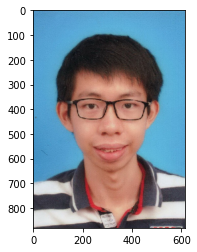

In [ ]:
my_photo_path = '/gdrive/MyDrive/Colab Notebooks/SC project/Ooi Xin Peng 17204999.jpeg'
run_app(my_photo_path)